# EY NextWave Data Science Competition 2019 - Final Submission

- <a href='#1'>1. Introduction</a>  
    - <a href='#1-1'>1.1. Problem Statement</a>
- <a href='#2'>2. General Overview </a>
- <a href='#3'>3. Importing Libraries and Data </a>
- <a href='#4'> 4. Feature Extraction</a>
    - <a href='#4-1'> 4.1. Distancial-directional Calculations</a>
        - <a href='#4-1-1'>4.1.1. City Center Midpoint Distances</a>
        - <a href='#4-1-2'>4.1.2. City Center Midpoint Directions</a>
        - <a href='#4-1-3'>4.1.3. City Center Border Distances</a>
        - <a href='#4-1-4'>4.1.4. City Center Vertex Angles</a>
    - <a href='#4-2'>4.2. Time-wise Features </a>
        - <a href='#4-2-1'>4.2.1. Time-wise: Continuous Features </a>
    - <a href='#4-3'>4.3. Quadrants </a>
    - <a href='#4-4'>4.4. Center features </a>
    - <a href='#4-5'>4.5. Blind trajectories features </a>
    - <a href='#4-6'>4.6. Trajectories' Origin Point Features</a>
- <a href='#7'> 7. Baseline Models </a>
    - <a href='#7-1'> 7.1. Logistic Regression</a>
    - <a href='#7-2'> 7.2. Random Forest</a>
    - <a href='#7-3'> 7.3. Gradient Boosting</a>
    - <a href='#7-4'> 7.4. Feature Importances </a>
- <a href='#9'> 9. Saving Train and Test Set preprocessed  </a>
- <a href='#10'> 10. Conclusion </a>

## <a id='3'>3. Importing Libraries and Data</a>

In [4]:
#!pip install tqdm
#!conda install shapely descartes geopandas -y

In [2]:
# general tools
import warnings
import requests
import pickle
import math
import re

# visualization tools
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns

# data preprocessing tools
import pandas as pd
from shapely.geometry import Point
import numpy as np


tqdm.pandas()
plt.style.use('seaborn')
warnings.filterwarnings("ignore")

%run ../src/utils.py

In [3]:
train = pd.read_csv('../data/raw/data_train.zip', index_col='Unnamed: 0', low_memory=True)
test = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)

train.shape, test.shape

((814262, 11), (202937, 11))

In [4]:
data = pd.concat([train, test], axis=0)

data.shape

(1017199, 11)

#### <a id='4-?-?'>4.?.?. Coordinate Conversion: Latitudes and Longitudes</a>

Even though originally formatted as cartesian xy coordinates, our dataset's `(x_entry, y_entry)` inputs represent real, lat-long points in real space - the center of Atlanta. Yet, for that fact to be mathematically present in our analysis, we must first convert such data to the appropriate geographic scale and form.

In [5]:
import pyproj

converter = pyproj.Proj("+proj=merc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 \
                    +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

data['lat_lon_entry'] = [converter(x, y, inverse=True) for x, y in zip(data.x_entry, data.y_entry)]

data['lon_entry'] = data.lat_lon_entry.apply(lambda row: row[0])
data['lat_entry'] = data.lat_lon_entry.apply(lambda row: row[1])

data['lat_lon_exit'] = [converter(x, y, inverse=True) for x, y in zip(data.x_exit, data.y_exit)]

data['lon_exit'] = data.lat_lon_exit.apply(lambda row: row[0])
data['lat_exit'] = data.lat_lon_exit.apply(lambda row: row[1])

#### <a id='4-?-?'>4.?.?. Mapping of City Hubs</a>

Equipped with the correct conversion of our points' coordinates, we can now begin mapping the most prominent hubs that centralize movimentation towards and outwards the city center.

In [6]:
with open('google_secret.pkl', 'rb') as fp:
    google_secret = pickle.load(fp)

In [7]:
gplaces = lambda api: f"https://maps.googleapis.com/maps/api/place/{api}/json?key={google_secret['key']}"

def places_nearby(lat, lon, radius=50000):
    url = gplaces('nearbysearch') + f'&location={lat},{lon}&radius={radius}'
    return requests.get(url).json()

def places_from_text(text):
    url = gplaces('findplacefromtext') + f'&input={text}&inputtype=textquery'
    return requests.get(url).json()

##### <a id='4-?-?-1'>4.?.?.1 Hub Areas</a>

Some of the most prominent hubs we'll be mapping centralize in specific perimeters which we can precise. Let's proceed to defining their boundaries in polygon form.

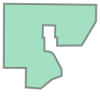

In [8]:
from shapely.geometry import Polygon, Point, LineString, LinearRing

# Atlanta University Center Area.
university_center = Polygon([
    (-84.417575, 33.744487), (-84.417535, 33.754717), (-84.402802, 33.754548), (-84.402827, 33.751915),
    (-84.405122, 33.748040), (-84.409062, 33.748023), (-84.409062, 33.749305), (-84.409396, 33.749340),
    (-84.409354, 33.751229), (-84.411314, 33.751282), (-84.411355, 33.749340), (-84.411105, 33.749323),
    (-84.411043, 33.747139), (-84.410467, 33.747122), (-84.409870, 33.746912), (-84.409576, 33.746584),
    (-84.408365, 33.744314), (-84.408299, 33.743229), (-84.409856, 33.742627), (-84.411665, 33.741168),
    (-84.414071, 33.741356), (-84.414038, 33.744237), (-84.413988, 33.744349), (-84.413984, 33.744354),
    (-84.41402, 33.7444620)
])

university_center

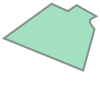

In [9]:
# Piedmont Hospital & Shepherd Clinic Area
piedmont_shepherd_medical_center = Polygon([
    (-84.393947, 33.806865), (-84.398492, 33.808707), (-84.395754, 33.810689), (-84.394822, 33.810267),
    (-84.394328, 33.810607), (-84.393199, 33.809974), (-84.393538, 33.809786), (-84.393566, 33.809598),
    (-84.393298, 33.809223)
])

piedmont_shepherd_medical_center

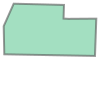

In [10]:
# Wellstar and Northlake Medical Area
wellstar_northlake_medical_center = Polygon([
    (-84.374930, 33.761479), (-84.374958, 33.762829), (-84.374478, 33.763908), (-84.372065, 33.763849),
    (-84.372084, 33.763194), (-84.371853, 33.763181), (-84.370513, 33.763191), (-84.370576, 33.761401)
])

wellstar_northlake_medical_center

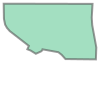

In [11]:
# Georgia Tech: Georgia Institute of Technology, Georgia Tech Library, Georgia Tech Campus Recreation Center
georgia_tech = Polygon([
    (-84.390448, 33.771274), (-84.396076, 33.771334), (-84.396764, 33.772106), (-84.397390, 33.772599),
    (-84.400322, 33.773132), (-84.400372, 33.772943), (-84.400585, 33.772749), (-84.401552, 33.772312),
    (-84.402544, 33.772922), (-84.403122, 33.773141), (-84.402848, 33.773768), (-84.406382, 33.776510),
    (-84.406893, 33.777099), (-84.407237, 33.777715), (-84.407455, 33.778798), (-84.407497, 33.781570),
    (-84.391070, 33.781537), (-84.391215, 33.778990), (-84.391121, 33.777578), (-84.390371, 33.773489)
])

# Additional block (southwest rectangle in the below plot): Georgia Tech Human Resources + G.I.T's Business Services
georgia_tech

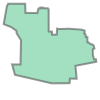

In [12]:
# Perimeter Center - Mostly shopping facilities:
# Shopping Center Perimeter Mall, Wallmart Supercenter, Mastermind Escape Games, Hobby Lobby
sandy_springs_perimeter_center = Polygon([
    (-84.346402, 33.910700), (-84.362482, 33.914431), (-84.363731, 33.918990), (-84.360035, 33.918948),
    (-84.359838, 33.929610), (-84.361736, 33.932622), (-84.361784, 33.933541), (-84.361854, 33.933727),
    (-84.364093, 33.935311), (-84.367405, 33.936621), (-84.367405, 33.936621), (-84.366124, 33.943892),
    (-84.366030, 33.944361), (-84.365476, 33.945573), (-84.357993, 33.945544), (-84.357881, 33.941539),
    (-84.352702, 33.941476), (-84.352183, 33.943451), (-84.351393, 33.943519), (-84.351405, 33.943871),
    (-84.350156, 33.943861), (-84.350179, 33.943587), (-84.348058, 33.943568), (-84.347717, 33.943050),
    (-84.347710, 33.933398), (-84.346254, 33.933337), (-84.346230, 33.931989), (-84.344168, 33.932049),
    (-84.344022, 33.934665), (-84.343173, 33.934464), (-84.339121, 33.934625), (-84.333822, 33.934252),
    (-84.333498, 33.934240), (-84.331973, 33.933830), (-84.331931, 33.932811), (-84.332128, 33.932542),
    (-84.331818, 33.932390), (-84.331493, 33.931938), (-84.331465, 33.931000), (-84.330766, 33.930971),
    (-84.330762, 33.928679), (-84.330289, 33.928650), (-84.329507, 33.927956), (-84.328445, 33.927677),
    (-84.327978, 33.927171), (-84.327677, 33.925931), (-84.328369, 33.925618), (-84.328376, 33.923131),
    (-84.327829, 33.921202), (-84.327016, 33.921250), (-84.326856, 33.920142), (-84.335989, 33.918374),
    (-84.335464, 33.912715), (-84.338407, 33.912768), (-84.338540, 33.910757)
])

sandy_springs_perimeter_center

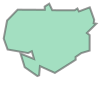

In [13]:
# Neighborhood: Buckhead. Ranked 5th in Population +8k (2010, per WalkScore)
buckhead = Polygon([
    (-84.393768, 33.796485), (-84.413277, 33.805354), (-84.414279, 33.793394), (-84.416613, 33.792424),
    (-84.433123, 33.803924), (-84.438549, 33.821659), (-84.420939, 33.814610), (-84.423859, 33.824808),
    (-84.428753, 33.822388), (-84.455423, 33.827032), (-84.460515, 33.841305), (-84.456124, 33.864782),
    (-84.442338, 33.878963), (-84.406974, 33.878794), (-84.407071, 33.882988), (-84.401165, 33.886757),
    (-84.397168, 33.878255), (-84.368004, 33.878174), (-84.364406, 33.880496), (-84.362410, 33.876680),
    (-84.348271, 33.881985), (-84.342491, 33.865670), (-84.343172, 33.861330), (-84.339755, 33.860690),
    (-84.352039, 33.848583), (-84.348440, 33.845847), (-84.348444, 33.825604), (-84.359226, 33.822417),
    (-84.366782, 33.817225), (-84.366611, 33.813660)
])

buckhead

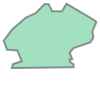

In [14]:
# Hartsfield-Jackson Atlanta International Airport
airport = Polygon([
    (-84.414702, 33.619520), (-84.451832, 33.619029), (-84.451144, 33.621420), (-84.445910, 33.623089),
    (-84.448543, 33.629590), (-84.454780, 33.630050), (-84.456709, 33.635485), (-84.451844, 33.641996),
    (-84.443409, 33.649377), (-84.437374, 33.652094), (-84.432200, 33.657475), (-84.429713, 33.657426),
    (-84.427592, 33.653181), (-84.421736, 33.653108), (-84.418990, 33.657692), (-84.401708, 33.647451),
    (-84.401080, 33.646555), (-84.403413, 33.641003), (-84.402845, 33.637268), (-84.404642, 33.634478),
    (-84.414836, 33.630963), (-84.417054, 33.628195), (-84.415513, 33.624280), (-84.417098, 33.624131),
    (-84.416859, 33.622587), (-84.414765, 33.621316)
])

airport

In [15]:
hub_areas = [airport,
             buckhead,
             georgia_tech,
             university_center,
             sandy_springs_perimeter_center,
             piedmont_shepherd_medical_center,
             wellstar_northlake_medical_center]

hub_areas_names = ['international_airport',
                   'buckhead',
                   'georgia_tech',
                   'atlanta_university_center',
                   'perimeter_center',
                   'piedmont_shepherd_medical_center',
                   'wellstar_northlake_medical_center']

hub_area_linear_rings = {name: LinearRing(area.exterior.coords) for area, name in zip(hub_areas, hub_areas_names)}

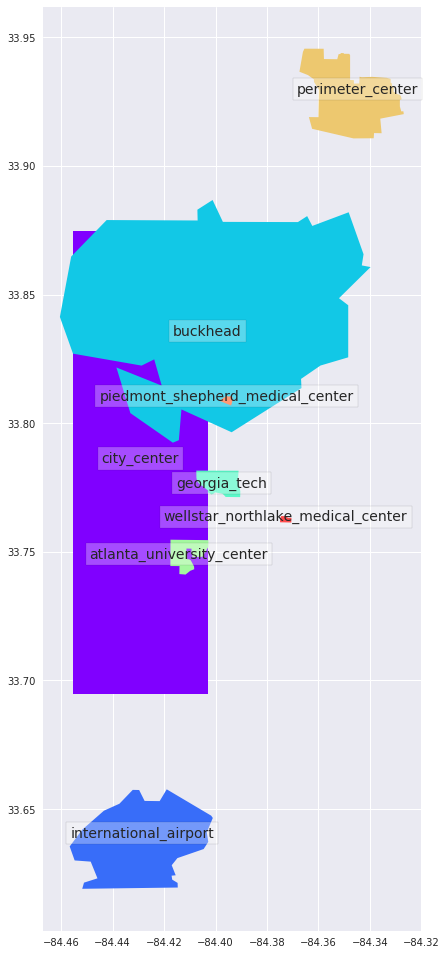

In [16]:
import geopandas as gpd
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, len(hub_areas)+1))
bbox = {'facecolor':'white', 'alpha':0.3}

gdf = gpd.GeoDataFrame({'geometry': [center_polygon_latlon] + hub_areas, 'name': ['city_center'] + hub_areas_names})
gdf['mid_coords'] = gdf.apply(lambda row: row.geometry.representative_point().coords[:][0], axis=1)

gdf.plot(color=colors, figsize=(15, 17))

_ = gdf.apply(lambda row: plt.annotate(s=row['name'], xy=row['mid_coords'], ha='center', fontsize=14, bbox=bbox), axis=1)

In [17]:
def distance_to_area_havr(lon, lat, area):
    # Closest border point considering a 2D, cartesian plane
    distance_in_polygon_ring = hub_area_linear_rings[name].project(Point(lon, lat))
    closest_latlon_in_border = hub_area_linear_rings[name].interpolate(distance_in_polygon_ring)
    
    closest_point_lon = closest_latlon_in_border.coords[0][0]
    closest_point_lat = closest_latlon_in_border.coords[0][1]
    # Haversine distance, projecting the border point spherically
    return haversine(lon, lat, closest_point_lon, closest_point_lat)

In [18]:
def distance_to_area_mid_havr(lon, lat, area):
    mid_point_lon = area.representative_point().coords[:][0][0]
    mid_point_lat = area.representative_point().coords[:][0][1]
    return haversine(lon, lat, mid_point_lon, mid_point_lat)

In [19]:
def crossed_area(x1, y1, x2, y2, area):
    if any(np.isnan([x1, y1, x2, y2])):
           return np.nan
    return 1 if LineString([(x1, y1), (x2, y2)]).intersects(area) else 0

In [95]:
import time
start = time.time()

for area, name in zip(hub_areas, hub_areas_names):
    
    #data[f'is_in_{name}_entry'] = data.progress_apply(
    #    lambda row: area.contains(Point(row.x_entry, row.y_entry)),
    #    axis=1
    #)
    
    #data[f'is_in_{name}_exit'] = data.progress_apply(
    #    lambda row: area.contains(Point(row.x_exit, row.y_exit)),
    #    axis=1
    #)
    
    #data[f'havr_{name}_entry'] = data.progress_apply(
    #    lambda row: distance_to_area_havr(row.lon_entry, row.lat_entry, name),
    #    axis=1
    #)
    
    #data[f'havr_{name}_exit'] = data.progress_apply(
    #    lambda row: distance_to_area_havr(row.lon_exit, row.lat_exit, name),
    #    axis=1
    #)
    
    data[f'havr_mid_{name}_entry'] = data.progress_apply(
        lambda row: distance_to_area_mid_havr(row.lon_entry, row.lat_entry, area),
        axis=1
    )
    
    data[f'havr_mid_{name}_exit'] = data.progress_apply(
        lambda row: distance_to_area_mid_havr(row.lon_exit, row.lat_exit, area),
        axis=1
    )
    
    #data[f'crossed_{name}'] = data.progress_apply(
    #    lambda row: crossed_area(row.x_entry, row.y_entry, row.x_exit, row.y_exit, area),
    #    axis=1
    #)
    
    data[f'{name}_permanency'] = data.progress_apply(lambda row: center_permanency(row, polygon=area), axis=1)

hub_areas_leakage = [
    x for x in data.columns if any(n in x for n in hub_areas_names) and any(s in x for s in ['crossed', 'permanency', 'exit'])
]

print('Time elapsed: {}'.format(time.time() - start))
data.head(10)


Time elapsed: 5490.155202627182


,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,is_inside_city_exit,leaving_city,entering_city,havr_mid_international_airport_exit,havr_mid_buckhead_exit,havr_mid_georgia_tech_exit,havr_mid_atlanta_university_center_exit,havr_mid_perimeter_center_exit,havr_mid_piedmont_shepherd_medical_center_exit,havr_mid_wellstar_northlake_medical_center_exit
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,0,0,0,11332.475342,10789.983621,11004.716105,11030.442737,10736.625991,10902.592504,11142.863611
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,0,0,0,10674.718709,10294.196223,10461.748906,10460.432108,10341.387650,10388.099246,10596.207039
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,0,0,0,10798.801984,10401.244225,10574.031122,10575.544704,10437.234594,10497.271075,10709.008623
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,0,0,0,10809.476533,10410.365493,10583.626358,10585.398164,10445.341816,10506.584085,10718.649684
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:38:09,14:38:09,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,...,0,0,0,10828.080855,10424.883151,10599.356773,10601.801191,10457.333917,10521.589143,10734.497681
5,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_5,15:02:31,15:18:33,NaN,NaN,NaN,3.744945e+06,-1.928183e+07,3.744785e+06,...,0,0,0,10850.269405,10445.195491,10620.273630,10623.037581,10476.278045,10542.148615,10755.470659
6,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_0,14:29:23,14:29:23,0.000000,0.000000,0.000000,3.749450e+06,-1.926506e+07,3.749450e+06,...,0,0,0,10776.943044,10326.254189,10513.831106,10523.942301,10333.191411,10428.119333,10650.176933
7,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_1,14:39:49,14:39:49,0.000000,0.000000,0.000000,3.749090e+06,-1.926726e+07,3.749090e+06,...,0,0,0,10778.243241,10331.673698,10518.106657,10527.546333,10340.888806,10433.089052,10654.355453
8,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_2,14:50:14,14:50:14,0.507809,0.507809,0.507809,3.749042e+06,-1.926632e+07,3.749042e+06,...,0,0,0,10783.947197,10337.106182,10523.634308,10533.122612,10346.083942,10438.560834,10659.890514
9,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_3,15:00:32,15:29:48,1.149404,1.149404,1.149404,3.749088e+06,-1.926605e+07,3.749610e+06,...,0,0,0,10767.993252,10316.707829,10504.420571,10514.622436,10323.446899,10418.623545,10640.778884


##### <a id='4-?-?-2'>4.?.?.2 Hub Points - Companies</a>

Most of the individual hubs - companies, universities, hospitals, banks etc - in Atlanta are sparsely distributed. Discovering wide areas with clusters of hospitals, hotels and other facilities is not enough to account for the majority of structures spread throughout the city space.

Therefore, let's map what we deem to be the most independently important points, starting by **biggest companies headquartered in Atlanta**.

In [21]:
!pip install geog

sagemaker 1.19.0 requires protobuf>=3.1, which is not installed.
requests-kerberos 0.12.0 requires pykerberos<2.0.0,>=1.1.8; sys_platform != "win32", which is not installed.
protobuf3-to-dict 0.1.5 requires protobuf>=2.3.0, which is not installed.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [22]:
import geog

def radius_around(lon, lat, meters=150):
    center = Point(lon, lat)
    
    n_points_in_radius_countour = meters
    angles = np.linspace(0, 360, n_points_in_radius_countour)
    
    return Polygon(geog.propagate(center, angles, meters))

In [23]:
# Biggest Company Headquarted in Atlanta: The Home Depot
# 400k employees (as per Zippia, 2018)

home_depot = {
    'id': 'home_depot',
    'labeled_radius': [
        (radius_around(-84.481507, 33.866303), None),
        (radius_around(-84.476268, 33.862436), None),
        (radius_around(-84.276796, 33.928848), None),
        (radius_around(-84.363365, 33.828984), None),
        (radius_around(-84.371127, 33.781003), None),
        (radius_around(-84.503138, 33.732405), None)
    ]
}

In [24]:
# 2nd Biggest Company Headquarted in Atlanta: United Parcel Service (UPS)
# 335k employees (as per Zippia, 20018)

ups = {
    'id': 'ups',
    'labeled_radius': [
        (radius_around(-84.467631, 33.891408), None),
        (radius_around(-84.462834, 33.876571), None),
        (radius_around(-84.539111, 33.771619), None),
        (radius_around(-84.560382, 33.748796), None)
    ]
}

In [25]:
# 3rd Biggest Company Headquarted in Atlanta: United Parcel Service (UPS)
# 125k employees (as per Zippia, 20018)

randstad = {
    'id': 'randstad',
    'labeled_radius': [
        (radius_around(-84.465801, 33.892477), None),
        (radius_around(-84.452059, 33.887668), None),
        (radius_around(-84.355332, 33.921719), None)
    ]
}

In [26]:
# 4th Biggest Company Headquarted in Atlanta: The Coca-Cola Company
# 100k employees (as per Zippia, 20018)

coca_cola = {
    'id': 'coca_cola',
    'labeled_radius': [(radius_around(33.770786, -84.397380), None)]
}

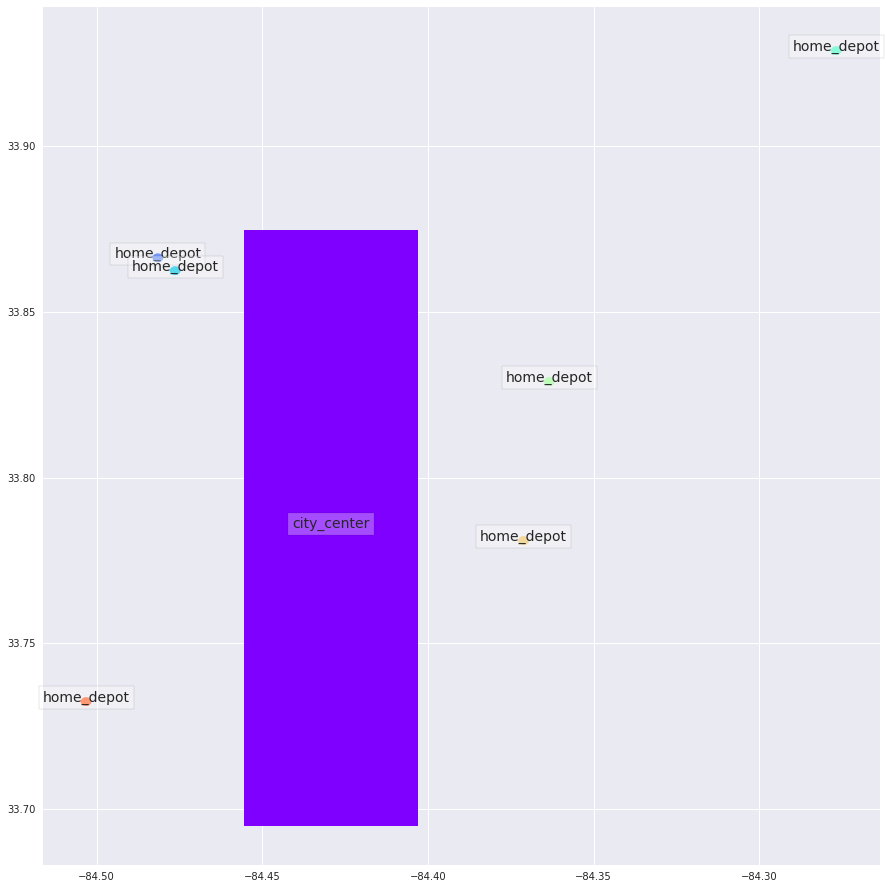

In [27]:
home_depot_radii = [radius for (radius, label) in home_depot['labeled_radius']]
home_depot_label = ['home_depot' for r in home_depot_radii]

colors = cm.rainbow(np.linspace(0, 1, len(hub_areas)+1))
bbox = {'facecolor':'white', 'alpha':0.3}

gdf = gpd.GeoDataFrame({'geometry': [center_polygon_latlon] + home_depot_radii, 'label': ['city_center'] + home_depot_label})
gdf['mid_coords'] = gdf.apply(lambda row: row.geometry.representative_point().coords[:][0], axis=1)

gdf.plot(color=colors, figsize=(15, 17))

_ = gdf.apply(lambda row: plt.annotate(s=row['label'], xy=row['mid_coords'], ha='center', fontsize=14, bbox=bbox), axis=1)

##### <a id='4-?-?-3'>4.?.?.3 Hub Points - Establishments</a>

Workplaces aside, let us keep track of a few of the remaining day-to-day places that commonly take parte in most people's routines.

In [28]:
airport_hotel = {
    'id': 'airport_hotel',
    'labeled_radius': [
        (radius_around(-84.453984, 33.624019), 'la_quinta'),
        (radius_around(-84.455526, 33.624089), 'fairfield'),
        (radius_around(-84.456444, 33.624245), 'courtyard'),
        (radius_around(-84.457715, 33.626953), 'westin'),
        (radius_around(-84.460988, 33.626745), 'marriott'),
        (radius_around(-84.462864, 33.625946), 'hilton'),
        (radius_around(-84.458637, 33.630328), 'holiday_1'),
        (radius_around(-84.452741, 33.627982), 'holiday_2'),
        (radius_around(-84.452634, 33.627162), 'holiday_3'),
        (radius_around(-84.429193, 33.661274), 'hampton'),
        (radius_around(-84.429193, 33.661274), 'hampton'),
    ]
}

In [29]:
shoppings = {
    'id': 'shopping',
    'labeled_radius': [
        (radius_around(-84.361553, 33.851987), 'lenox'),
        (radius_around(-84.522533, 33.899879), 'shops_belmont'),
        (radius_around(-84.470817, 33.886576), 'cumberland_mall'),
        (radius_around(-84.415777, 33.740525), 'the_mall_west_end'),
        (radius_around(-84.340890, 33.924048), 'perimeter_mall')
    ]
}

In [30]:
subway = {
    'id': 'subway',
    'labeled_radius': [
        (radius_around(-84.397380, 33.770786), 'civic'),
        (radius_around(-84.387791, 33.758010), 'peachtree'),
        (radius_around(-84.404011, 33.756656), 'vine_city'),
        (radius_around(-84.396802, 33.756370), 'dome_gwcc'),
        (radius_around(-84.416627, 33.756157), 'ashby'),
        (radius_around(-84.428817, 33.772638), 'bankhead'),
        (radius_around(-84.396203, 33.748949), 'garnett'),
        (radius_around(-84.386622, 33.780696), 'midtown')
    ]
}

In [31]:
bus = {
    'id': 'bus',
    'labeled_radius': [
        (radius_around(-84.391989, 33.755195), 'five_points')
    ]
}

In [32]:
school = {
    'id': 'school',
    'labeled_radius': [
        (radius_around(-84.422356, 33.732873), 'protocol'),
        (radius_around(-84.411884, 33.743401), 'morehouse'),
        (radius_around(-84.435033, 33.743826), 'kipp_strive'),
        (radius_around(-84.396159, 33.803970), 'public'),
        (radius_around(-84.433310, 33.847719), 'westminster'),
        (radius_around(-84.422421, 33.841577), 'speech'),
        (radius_around(-84.424299, 33.842820), 'girls'),
        (radius_around(-84.415776, 33.830002), 'morris_brandon')
    ]
}

In [33]:
college = {
    'id': 'college',
    'labeled_radius': [
        (radius_around(-84.395867, 33.777712), 'georgia_inst_tech'),
        (radius_around(-84.399901, 33.769009), 'bauder'),
        (radius_around(-84.411182, 33.751701), 'atlanta')
    ]
}

In [34]:
market = {
    'id': 'market',
    'labeled_radius': [
        (radius_around(-84.413664, 33.794707), 'floral_park'),
        (radius_around(-84.398249, 33.791839), 'christkindl')
    ]
}

In [35]:
hospital = {
    'id': 'hospital',
    'labeled_radius': [
        (radius_around(-84.382010, 33.751821), 'grady'),
        (radius_around(-84.386428, 33.768586), 'fresenius')
    ]
}

In [121]:
hospital['labeled_radius'][0][0].centroid.coords[0]

(-84.38200999999997, 33.751821002648185)

In [ ]:
categories = [home_depot, ups, randstad, coca_cola, shoppings, subway, bus, school, college, market, hospital]

for c in categories:
    idx = None
    catid = c['id']
    labeled_pts = c['labeled_radius']
    
    if any(label is None for (_, label) in labeled_pts):
        idx = [f"{catid}_{i}" for i in range(1, len(labeled_pts)+1)]
    else:
        idx = [f"{catid}_{label}" for (_, label) in labeled_pts]
    
    for i, (pt, label) in enumerate(labeled_pts):
        lon_pt, lat_pt = pt.centroid.coords[0]
        lonlat_entry = zip(data.lon_entry, data.lat_entry)
        lonlat_exit = zip(data.lon_exit, data.lat_exit)
        
        data[f'havr_{idx[i]}_entry'] = [haversine(lon, lat, lon_pt, lat_pt) for lon, lat in lonlat_entry]
#         data[f'havr_{idx[i]}_exit'] = [haversine(lon, lat, lon_pt, lat_pt) for lon, lat in lonlat_exit]
#         data[f'delta_havr_{idx[i]}_blind'] = data[f'havr_{idx[i]}_entry'] - data.groupby('hash')[f'havr_{idx[i]}_exit'].shift(1)

## <a id='4'>4. Feature Extraction </a>

In this section, we will build new features for our data. Here we will explore the time component of the data, as well as distances, angles, how each trajectory relates to the city center, etc. Also, in order to achieve a better score, we need to construct the data accordingly to its sequential format.

### <a id='4-1'>4.1. Distancial-directional Calculations </a>

Distance is a primary factor in comparing two points in a cartesian plane. It is then reasonable to calculate a couple of different distance formulas for points throughout our dataset:

- Euclidean distance is defined as length of the smallest straight line connecting two points in cartesian space, e.g. points $p$ and $q$, being:
$$
d(p, q) = d(q, p) = \sqrt{\sum_{i=1}^{n}(q_i - p_i)^2}
$$
- Manhattan distance, also known as taxicab metric and L1 distance, comprises the sum of projections of a given line in each of its plane's axes:
$$
d(X, Y) = \sum_{i=1}^{n}|x_i - y_i|^p
$$
- And, finally, Haversine, which gives the distance between two points over a spherical surface.
$$
d = 2r \arcsin\left(\sqrt{\sin^2\left(\frac{\varphi_2 - \varphi_1}{2}\right) + \cos(\varphi_1) \cos(\varphi_2)\sin^2\left(\frac{\lambda_2 - \lambda_1}{2}\right)}\right)
$$

In [36]:
data['euclidean_distance'] = euclidean(data.x_entry.values, data.y_entry.values, data.x_exit.values, data.y_exit.values)

data['manhattan_distance'] = manhattan(data.x_entry.values, data.y_entry.values, data.x_exit.values, data.y_exit.values)

data['harvesine_distance'] = haversine(data.lon_entry.values, data.lat_entry.values, data.lon_exit.values, data.lat_exit.values)

In [37]:
data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,is_in_wellstar_northlake_medical_center_entry,is_in_wellstar_northlake_medical_center_exit,havr_wellstar_northlake_medical_center_entry,havr_wellstar_northlake_medical_center_exit,havr_mid_wellstar_northlake_medical_center_entry,crossed_wellstar_northlake_medical_center,wellstar_northlake_medical_center_permanency,euclidean_distance,manhattan_distance,harvesine_distance
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,False,False,11303.584829,11153.649844,11142.863611,0.0,0.0,42364.863118,43047.231426,242.408486
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,False,False,10634.620595,10606.963923,10596.207039,0.0,0.0,2989.643628,3841.346373,58.378272
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,False,False,10714.949280,10719.779018,10709.008623,0.0,0.0,725.658561,776.090116,4.881699
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,False,False,10719.582573,10729.421191,10718.649684,0.0,0.0,1804.576849,1874.414413,10.650402


Some patterns in data distribution can already be analyzed from theses distance computations. Let's analyze the Euclidean distance values among train and test data to gain a closer perception.

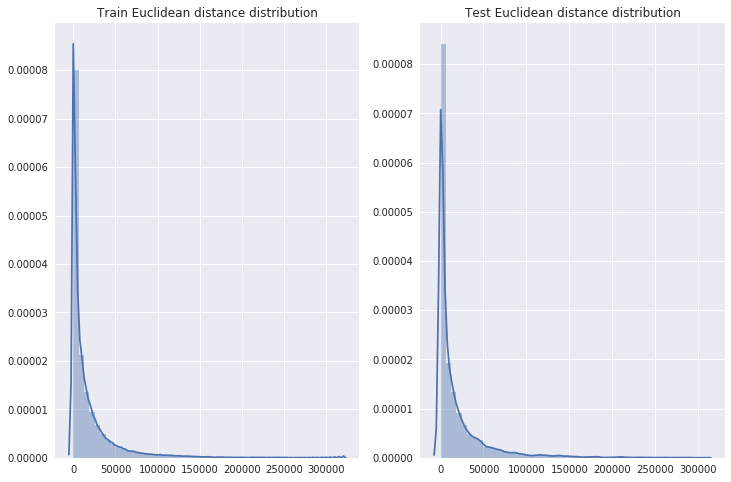

In [38]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 8))
ax1.set_title('Train Euclidean distance distribution')
ax2.set_title('Test Euclidean distance distribution')

distplot(data[data.hash.isin(train.hash)], 'euclidean_distance', ax=ax1)
distplot(data[data.hash.isin(test.hash)], 'euclidean_distance', ax=ax2)

In [39]:
# Percentage of 0-valued distances among all non-NaN euclidean values.
data[data.euclidean_distance == 0.0].shape[0] / data[~np.isnan(data.euclidean_distance)].shape[0]

0.5339448440759431

In [40]:
# Percentage of 0-valued distances having time entry equal to time exit
data[
    (data.euclidean_distance == 0.0) & (data.time_exit == data.time_entry)
].shape[0] / data[data.euclidean_distance == 0.0].shape[0]

0.9975972568364897

The above shows us that more than half of _all_ filled distances in our sets are 0-valued - and basically all those 0 distance trajectories start and end **at the same time**.

This means that target predictions over those points would only need to check whether the trajectory starts inside the city center. Since the coordinates will stay the same, so will that status.

For these reasons, we will sample as trainable data only points having euclidean distances different than 0.

In [41]:
percentage_zeros = data[data.euclidean_distance==0]
percentage_zeros = (percentage_zeros.groupby('hash').trajectory_id.count() 
                    / data.groupby('hash').trajectory_id.count()).reset_index()
percentage_zeros.columns = ['hash', 'zeros_in_trajectory']

In [42]:
#data = data[data.euclidean_distance!=0]
data.shape

(1017199, 69)

#### <a id='4-1-1'>4.1.1. City Center Midpoint Distances</a>

Since we want to determine a trajectory's end coordinates as being either in or out of the city center, current-to-center-midpoint distance can be a determinant feature. Let's compute those differences.

In [43]:
center_lon, center_lat = converter(center['x_mid'], center['y_mid'], inverse=True)

data['eucl_dist_cc_entry'] = euclidean(data.x_entry.values, data.y_entry.values, center['x_mid'], center['y_mid'])
data['eucl_dist_cc_exit'] = euclidean(data.x_exit.values, data.y_exit.values, center['x_mid'], center['y_mid'])

data['manh_dist_cc_entry'] = manhattan(data.x_entry.values, data.y_entry.values, center['x_mid'], center['y_mid'])
data['manh_dist_cc_exit'] = manhattan(data.x_exit.values, data.y_exit.values, center['x_mid'], center['y_mid'])

data['havr_dist_cc_entry'] = haversine(data.lon_entry.values, data.lat_entry.values, center_lon, center_lat)
data['havr_dist_cc_exit'] = haversine(data.lon_exit.values, data.lat_exit.values, center_lon, center_lat)

data['eucl_diff_cc_exit_entry'] = data.eucl_dist_cc_exit - data.eucl_dist_cc_entry
data['manh_diff_cc_exit_entry'] = data.manh_dist_cc_exit - data.manh_dist_cc_entry
data['havr_diff_cc_exit_entry'] = data.havr_dist_cc_exit - data.havr_dist_cc_entry

In [44]:
data['x_diff_entry'] = data.x_entry.values - center['x_mid']
data['x_diff_exit'] = data.x_exit.values - center['x_mid']

data['y_diff_entry'] = data.y_entry.values - center['y_mid']
data['y_diff_exit'] = data.y_exit.values - center['y_mid']

#### <a id='4-1-2'>4.1.2. City Center Midpoint Directions</a>

Differences from entry and exit points to center middle can also be angularly significant as that can reveal how trajectories are bent towards the midpoint.

In [45]:
directions_entry = []
for x, y in zip(data.x_diff_entry, data.y_diff_entry):
    directions_entry.append(math.atan2(x, y))
    
data['direction_entry'] = directions_entry

In [46]:
directions_exit = []
for x, y in zip(data.x_diff_exit, data.y_diff_exit):
    directions_exit.append(math.atan2(x, y))
    
data['direction_exit'] = directions_exit

#### <a id='4-1-3'>4.1.3. City Center Border Distances</a>

Our predefined city center is a rectangle (see below). Each of its borders represent the very boundaries that will ultimately define if a trajectory is inside the center - or not - so it seems logical to compute the minimum distance to all borders.

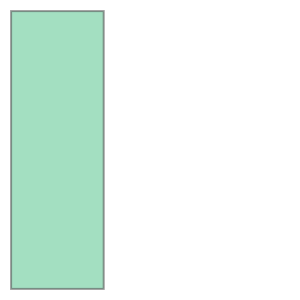

In [47]:
center_polygon

In [58]:
def distance_to_border(x, y, side):
    return center[side + '_border'].distance(Point(x, y))

for side in ['left', 'right', 'lower', 'upper']:
    data[f'distance_{side}_border'] = [distance_to_border(x, y, side=side) for x, y in zip(data.x_entry, data.y_entry)]

In [59]:
from shapely.geometry import Point

def distance_to_border_haversine(lon, lat, side):
    border = center[side + '_latlon_border']
    # Closest border point considering a 2D, cartesian plane
    closest_latlng_in_border = border.interpolate(border.project(Point(lon, lat)))
    
    closest_point_lon = closest_latlng_in_border.coords[0][0]
    closest_point_lat = closest_latlng_in_border.coords[0][1]
    # Haversine distance, projecting the border point spherically
    return haversine(lon, lat, closest_point_lon, closest_point_lat)

for side in ['left', 'right', 'lower', 'upper']:
    data[f'distance_{side}_latlon_border'] = [distance_to_border_haversine(x, y, side=side) for x, y in zip(data.lon_entry, data.lat_entry)]

#### <a id='4-1-4'>4.1.4. City Center Vertex Angles</a>

Onto the same motivation for the above, we will also compute the angles from every entry w.r.t. the city center's **vertexes**. That'll generate features more connected to the directional aspects of entry coordinates for each of those vertexes.

In [60]:
data['last_x_entry'] = data.groupby('hash').x_exit.shift(1)
data['last_y_entry'] = data.groupby('hash').y_exit.shift(1)

angle_cols = [
    'cc_middle_angle', 'cc_xmin_ymin_angle', 'cc_xmax_ymin_angle', 'cc_xmin_ymax_angle', 'cc_xmax_ymax_angle'
]

if angle_cols[0] in data.columns.tolist():
    data = data.drop(columns=angle_cols)
data = data.reindex(columns=data.columns.tolist() + angle_cols)

data = data.progress_apply(entry_to_center_angles, axis=1)

data = data.drop(columns=['last_x_entry', 'last_y_entry'])

data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,distance_upper_border,distance_left_latlon_border,distance_right_latlon_border,distance_lower_latlon_border,distance_upper_latlon_border,cc_middle_angle,cc_xmin_ymin_angle,cc_xmax_ymin_angle,cc_xmin_ymax_angle,cc_xmax_ymax_angle
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,114924.969304,647.341949,1202.452563,980.682735,647.316662,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,113775.281047,477.194923,1481.624996,477.194923,729.835687,0.137059,0.038653,0.188293,0.042244,0.310604
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,84874.048910,351.002060,1402.231948,351.002060,568.256114,0.198812,0.120334,0.476339,0.057555,0.234039
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,83601.282594,347.667383,1400.630977,347.667383,562.057663,0.173281,0.132425,0.711798,0.044184,0.184758


In [61]:
# Angle conversion: rads to degrees
data[angle_cols] = data[angle_cols] * 180.0 / np.pi
data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,distance_upper_border,distance_left_latlon_border,distance_right_latlon_border,distance_lower_latlon_border,distance_upper_latlon_border,cc_middle_angle,cc_xmin_ymin_angle,cc_xmax_ymin_angle,cc_xmin_ymax_angle,cc_xmax_ymax_angle
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,114924.969304,647.341949,1202.452563,980.682735,647.316662,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,113775.281047,477.194923,1481.624996,477.194923,729.835687,7.852886,2.214659,10.788397,2.420383,17.796301
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,84874.048910,351.002060,1402.231948,351.002060,568.256114,11.391105,6.894649,27.292186,3.297664,13.409474
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,83601.282594,347.667383,1400.630977,347.667383,562.057663,9.928271,7.587407,40.782997,2.531528,10.585844


### <a id='4-2'>4.2. Time-wise Features </a>

Trajectories in our context are also deeply rooted in their temporal distributions. Let us then start exploring those features by isolating them in hour, minute, and delta values.

In [62]:
data['minute_entry'] = data.time_exit.progress_apply(lambda x: int(x.split(':')[1]))
data['minute_exit']  = data.time_exit.progress_apply(lambda x: int(x.split(':')[1]))

data['hour_entry'] = data.time_entry.progress_apply(lambda x: int(x.split(':')[0]))
data['hour_exit']  = data.time_exit.progress_apply(lambda x: int(x.split(':')[0]))

data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit']  = pd.to_timedelta(data.time_exit)

data['timedelta'] = (data.time_exit - data.time_entry) / pd.Timedelta(minutes=1)

#### <a id='4-2-1'>4.2.1. Time-wise: Continuous Features </a>

The relationship of a trajectory with time may not only be related to the discrete (integer) representation of entry/exit occurence times: continuous representations of those will supposedly lead us closer to revealing different patterns spread throughout different parts of an hour or minute.

In [63]:
data['hours_continuous'] = [t / pd.Timedelta(hours=1) for t in data.time_entry]
data['minutes_continuous'] = [t / pd.Timedelta(minutes=1) for t in data.time_entry]

### <a id='4-3'>4.3. Quadrants </a>

Trajectory sparsity along the city center is an important factor when trying to identify patterns that may be enclosed in a particular center quadrant. Let us compute features acknowledging such relation by dividing the city center in four quadrants.

In [64]:
x_center = center['x_min'] + ((center['x_max']-center['x_min'])/2)
y_center = center['y_min'] + ((center['y_max']-center['y_min'])/2)

In [65]:
def quadrant_computation(x, y, which):
    if which == 'third':
        if center['x_min'] <= x <= x_center and center['y_min'] <= y <= y_center:
            return 1
        else:
            return 0
        
    elif which == 'first':
        if center['x_min'] <= x <= x_center and center['y_max'] >= y >= y_center:
            return 1
        else:
            return 0
        
    elif which == 'fourth':
        if center['x_max'] >= x >= x_center and center['y_min'] >= y >= y_center:
            return 1
        else:
            return 0
    elif which == 'second':
        if center['x_max'] >= x >= x_center and center['y_min'] <= y <= y_center:
            return 1
        else:
            return 0
    else:
        return 0
        
for quadrant in ['first', 'second', 'third', 'fourth']:
    data[quadrant+'_quadrant_entry'] = [quadrant_computation(x, y, which=quadrant) 
                                        for x, y in zip(data.x_entry, data.y_entry)]

### <a id='4-4'>4.4. Center features </a>

We can work with features related to center computation. Here, two more features are created: center_permanency, that encloses how much of the trajectory was inside the city center and has_crossed_city, that will indicate that a trajectory crossed city center.

In [66]:
data['center_permanency'] = data.progress_apply(center_permanency, axis=1)
data['crossed_city'] = data.progress_apply(crossed_city, axis=1)

### <a id='4-5'>4.5. Blind trajectories features </a>

One of the major issues in the data set and in the problem statement is that a lot of device IDs have blind trajectories, that is, they have different positions for the last exit and current entry postions. Therefore, we need to explore data to acquire information regarding this blind spots. 

In [67]:
# time passed between blind spots
data['timedelta_blind'] = (data.time_entry - data.time_exit.shift(1)) / pd.Timedelta(minutes=1)

# delta for x and y blind
data['x_delta_blind'] = data.x_entry - data.groupby('hash').x_exit.shift(1)
data['y_delta_blind'] = data.y_entry - data.groupby('hash').y_exit.shift(1)

data['lon_delta_blind'] = data.lon_entry - data.groupby('hash').lon_exit.shift(1)
data['lat_delta_blind'] = data.lat_entry - data.groupby('hash').lat_exit.shift(1)

data['euclidean_distance_blind'] = np.sqrt(np.power(data.x_delta_blind.values, 2) 
                                     + np.power(data.y_delta_blind.values, 2))

data['manhattan_distance_blind'] = (np.abs(data.x_delta_blind.values) 
                                + np.abs(data.y_delta_blind.values))

data['haversine_distance_blind'] = haversine(data.lon_entry, data.lat_entry, 
                                             data.groupby('hash').lon_exit.shift(1), 
                                             data.groupby('hash').lat_exit.shift(1))

In [68]:
data['trajectory_number'] = data.trajectory_id.progress_apply(lambda x: int(re.findall('_\d+$', x)[0].strip('_')))

### <a id='4-6'>4.6. Trajectories' Origin Point Features</a>

It is a logical estimate that an extensive group in all recorded trajectories will eventually return to their origin point in the day - relating, in this case, to a person's return home. Dealing with paths distributed in space and time, the current-point to origin-point correlation levels hold a considerable chance to be proportional to any either spatial coordinates, time, or both.

With that in mind, let us then compute features focused on current-to-origin point differences.

In [69]:
border_cols = [f'distance_{x}_border' for x in ['left', 'right', 'upper', 'lower']]

col_subset = ['time_entry', 'time_exit', 'x_entry', 'y_entry', 'x_exit', 'y_exit',
              'center_permanency', 'manh_dist_cc_entry'] + border_cols

df_last = pd.DataFrame(data.groupby('hash')[col_subset].shift(1))
df_last.columns = [f'last_{c}' for c in df_last.columns]
data[df_last.columns.tolist()] = df_last

origin_points = data.groupby('hash').nth(0)[col_subset]
origin_points.columns = [f'origin_{c}' for c in col_subset]

In [70]:
if data.columns.contains('origin_time_entry'):
    data = data.drop(columns=origin_points.columns.tolist())
data = data.merge(origin_points.reset_index(), on='hash')

In [71]:
for p in ['last', 'origin']:
    data[f'deltat_{p}_entry'] = (data.time_entry - data[f'{p}_time_entry']) / pd.Timedelta(minutes=1)
    data[f'deltat_{p}_exit'] = (data.time_entry - data[f'{p}_time_exit']) / pd.Timedelta(minutes=1)

    data = data.drop(columns=[x for x in data.columns.ravel() if x.startswith(f'{p}_time_')])

    data[f'deltad_{p}_entry'] = euclidean(data[f'{p}_x_entry'], data[f'{p}_y_entry'], data.x_entry, data.y_entry)
    data[f'deltad_{p}_exit'] = euclidean(data[f'{p}_x_exit'], data[f'{p}_y_exit'], data.x_entry, data.y_entry)
    
    data[f'delta_{p}_manh_dist_cc_entry'] = data.manh_dist_cc_entry - data[f'{p}_manh_dist_cc_entry']
    data[f'delta_{p}_center_permanency'] = data.center_permanency - data[f'{p}_center_permanency']
    
    for border in border_cols:
        data[f'delta_{p}_{border}'] = data[border] - data[f'{p}_{border}']

data.head(5)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,deltat_origin_entry,deltat_origin_exit,deltad_origin_entry,deltad_origin_exit,delta_origin_manh_dist_cc_entry,delta_origin_center_permanency,delta_origin_distance_left_border,delta_origin_distance_right_border,delta_origin_distance_upper_border,delta_origin_distance_lower_border
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,0.000000,-4.016667,0.000000,42364.863118,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,16.050000,12.033333,228596.463182,186237.235350,-54286.455246,0.0,-60912.224781,-56666.776143,-1149.688256,-120912.169950
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,49.016667,45.000000,199678.885516,157319.709924,-84119.710003,0.0,-89538.276553,-80774.526606,-30050.920393,-149538.221722
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,73.316667,69.300000,198403.955748,156044.897162,-85407.114016,0.0,-90778.051448,-81648.292623,-31323.686710,-150777.996617
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:38:09,14:38:09,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,...,453.633333,449.616667,191701.580920,149343.344205,-92140.824906,0.0,-97201.822669,-85749.216239,-38011.785174,-157201.767838


For hashes containing only one trajectory, `origin` features **are the features of that one trajectory** - keeping origin features such as exit coordinates, and training upon them, will most likely lead to overfitting. Let's remove leakage-prone `origin` features for one-trajectory hashes.

In [72]:
origin_leakage_cols = ['origin_x_exit', 'origin_y_exit', 'origin_center_permanency']

In [73]:
one_trajectory = (data.groupby('hash').trajectory_id.nunique() == 1).reset_index()
one_trajectory.columns = ['hash', 'one_only']
one_trajectory = one_trajectory[one_trajectory.one_only == 1]

data[data.hash.isin(one_trajectory.hash)].head(5)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,deltat_origin_entry,deltat_origin_exit,deltad_origin_entry,deltad_origin_exit,delta_origin_manh_dist_cc_entry,delta_origin_center_permanency,delta_origin_distance_left_border,delta_origin_distance_right_border,delta_origin_distance_upper_border,delta_origin_distance_lower_border
651,003701810d0b3e69732ec05654769d16_9,traj_003701810d0b3e69732ec05654769d16_9_3,15:08:27,15:13:36,NaN,NaN,NaN,3.759756e+06,-1.911922e+07,3.758231e+06,...,0.0,-5.150000,0.0,22418.857599,0.0,0.0,0.0,0.0,0.0,0.0
1348,00713e9907826da5e8b6ddefcba51770_3,traj_00713e9907826da5e8b6ddefcba51770_3_0,15:24:03,15:24:26,NaN,NaN,NaN,3.742580e+06,-1.928732e+07,3.742601e+06,...,0.0,-0.383333,0.0,6764.064854,0.0,0.0,0.0,0.0,0.0,0.0
1515,0082a8207f0a1240210aa02f14921394_5,traj_0082a8207f0a1240210aa02f14921394_5_0,14:59:04,15:09:00,NaN,NaN,NaN,3.758777e+06,-1.912366e+07,3.760882e+06,...,0.0,-9.933333,0.0,15268.099068,0.0,0.0,0.0,0.0,0.0,0.0
2231,00c04d3c0b35f93429fe0fc32eff21f8_29,traj_00c04d3c0b35f93429fe0fc32eff21f8_29_0,14:59:15,15:03:13,NaN,NaN,NaN,3.743534e+06,-1.928686e+07,3.744788e+06,...,0.0,-3.966667,0.0,6213.466804,0.0,0.0,0.0,0.0,0.0,0.0
2556,00dd3e54b391a940c425e38d2236d404_11,traj_00dd3e54b391a940c425e38d2236d404_11_0,15:07:24,15:13:46,67.117546,67.117546,67.117546,3.745866e+06,-1.920858e+07,3.744994e+06,...,0.0,-6.366667,0.0,77821.319756,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
data.loc[data.hash.isin(one_trajectory.hash), origin_leakage_cols] = np.nan

In [75]:
data.shape

(1017199, 159)

### <a id='4-7'>4.7. Aggregating Features </a>

For every feature created, let's now create more feature based on some statistics. Thus we will group data by hash and compute its mean, max, sum, std and median values. We have to watch out not to compute features that would introduce leakage, that is why we we going to calculate statistics based only on data before 15 oclock.

In [76]:
# exclude data between 15-16 to avoid leakage
data_to_calculate_features = data[data.time_exit < pd.to_timedelta('15:00:00')]

agg_features = (data_to_calculate_features.groupby('hash')
               .agg(['min', 'max', 'mean', 'std', 'median'])
               .reset_index())

agg_features.columns = ['hash'] + ["_".join(x) for x in agg_features.columns.ravel() if x[0] is not 'hash']
agg_features.head(4)

,hash,vmax_min,vmax_max,vmax_mean,vmax_std,vmax_median,vmin_min,vmin_max,vmin_mean,vmin_std,...,delta_origin_distance_upper_border_min,delta_origin_distance_upper_border_max,delta_origin_distance_upper_border_mean,delta_origin_distance_upper_border_std,delta_origin_distance_upper_border_median,delta_origin_distance_lower_border_min,delta_origin_distance_lower_border_max,delta_origin_distance_lower_border_mean,delta_origin_distance_lower_border_std,delta_origin_distance_lower_border_median
0,0000a8602cf2def930488dee7cdad104_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-38011.785174,0.000000,-20107.216107,18089.693633,-30050.920393,-157201.767838,0.0,-115686.031226,66165.594476,-149538.221722
1,0000cf177130469eeac79f67b6bcf3df_9,0.000000,0.507809,0.169270,0.293184,0.000000,0.000000,0.507809,0.169270,0.293184,...,0.000000,2217.265141,1166.114282,1113.094164,1281.077706,-1669.889095,0.0,-868.090300,836.915957,-934.381805
2,0001f97b99a80f18f62e2d44e54ef33d_3,32.196255,32.196255,32.196255,NaN,32.196255,32.196255,32.196255,32.196255,NaN,...,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.0,0.000000,NaN,0.000000
3,0002124248b0ca510dea42824723ccac_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-30708.115509,0.000000,-15001.803780,13190.045820,-7741.975980,-65187.764178,0.0,-26625.360179,24379.260477,-24981.800315


### <a id='4-8'>4.8. Target </a>

The one necessary feature to compute, to help answering the final question: which trajectories are in and out of the city center?

In [77]:
data['is_inside_city_entry'] = [is_inside_city(x, y) for x, y in zip(data.x_entry, data.y_entry)]
data['is_inside_city_exit'] = [is_inside_city(x, y) for x, y in zip(data.x_exit, data.y_exit)]

data['leaving_city'] = (data.is_inside_city_entry - data.is_inside_city_exit).apply(lambda x: 1 if x == 1 
                                                                                   else 0)
data['entering_city'] = (data.is_inside_city_entry - data.is_inside_city_exit).apply(lambda x: 1 if x == -1 
                                                                                   else 0)

## <a id='5'>5. Sequence Data </a>

In [96]:
window_reference = 5

grouped = data.groupby(['hash']).tail(window_reference)
grouped['sequence'] = np.ones(grouped.shape[0])
df = grouped.groupby(by=['hash','time_entry', 'trajectory_id']).sum().groupby(level=[0]).cumsum().reset_index()[['trajectory_id', 'sequence']]
df.columns = ['trajectory_id', 'trajectory_sequence']
grouped = grouped.merge(df, on='trajectory_id', how='left')

In [97]:
hash_count_trajectories = grouped.groupby(['hash']).trajectory_id.count().reset_index()
hash_count_trajectories.columns = ['hash', 'count_trajectories']

grouped = grouped.merge(hash_count_trajectories, on='hash', how='left')
grouped.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,havr_mid_international_airport_exit,havr_mid_buckhead_exit,havr_mid_georgia_tech_exit,havr_mid_atlanta_university_center_exit,havr_mid_perimeter_center_exit,havr_mid_piedmont_shepherd_medical_center_exit,havr_mid_wellstar_northlake_medical_center_exit,sequence,trajectory_sequence,count_trajectories
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,10674.718709,10294.196223,10461.748906,10460.432108,10341.387650,10388.099246,10596.207039,1.0,1.0,5
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,10798.801984,10401.244225,10574.031122,10575.544704,10437.234594,10497.271075,10709.008623,1.0,2.0,5
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,10809.476533,10410.365493,10583.626358,10585.398164,10445.341816,10506.584085,10718.649684,1.0,3.0,5
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:38:09,14:38:09,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,...,10828.080855,10424.883151,10599.356773,10601.801191,10457.333917,10521.589143,10734.497681,1.0,4.0,5


In [98]:
ref = window_reference
for i in range(1, window_reference):
    grouped.loc[grouped.count_trajectories==i, 'trajectory_sequence'] += ref-1
    ref -= 1
    
grouped.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,havr_mid_international_airport_exit,havr_mid_buckhead_exit,havr_mid_georgia_tech_exit,havr_mid_atlanta_university_center_exit,havr_mid_perimeter_center_exit,havr_mid_piedmont_shepherd_medical_center_exit,havr_mid_wellstar_northlake_medical_center_exit,sequence,trajectory_sequence,count_trajectories
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,10674.718709,10294.196223,10461.748906,10460.432108,10341.387650,10388.099246,10596.207039,1.0,1.0,5
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,10798.801984,10401.244225,10574.031122,10575.544704,10437.234594,10497.271075,10709.008623,1.0,2.0,5
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,10809.476533,10410.365493,10583.626358,10585.398164,10445.341816,10506.584085,10718.649684,1.0,3.0,5
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:38:09,14:38:09,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,...,10828.080855,10424.883151,10599.356773,10601.801191,10457.333917,10521.589143,10734.497681,1.0,4.0,5


In [99]:
grouped = grouped.drop(['sequence', 'count_trajectories'], axis=1)

In [100]:
data_sequence = grouped.groupby(['hash', 'trajectory_sequence']).mean().unstack()
data_sequence.shape

(167578, 820)

In [101]:
data_sequence.columns = ['_'.join([x[0], str(int(x[1]))]) for x in data_sequence.columns.ravel()]
data_sequence.head(3)

,vmax_1,vmax_2,vmax_3,vmax_4,vmax_5,vmin_1,vmin_2,vmin_3,vmin_4,vmin_5,...,havr_mid_piedmont_shepherd_medical_center_exit_1,havr_mid_piedmont_shepherd_medical_center_exit_2,havr_mid_piedmont_shepherd_medical_center_exit_3,havr_mid_piedmont_shepherd_medical_center_exit_4,havr_mid_piedmont_shepherd_medical_center_exit_5,havr_mid_wellstar_northlake_medical_center_exit_1,havr_mid_wellstar_northlake_medical_center_exit_2,havr_mid_wellstar_northlake_medical_center_exit_3,havr_mid_wellstar_northlake_medical_center_exit_4,havr_mid_wellstar_northlake_medical_center_exit_5
hash,,,,,,,,,,,,,,,,,,,,,
0000a8602cf2def930488dee7cdad104_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10388.099246,10497.271075,10506.584085,10521.589143,10542.148615,10596.207039,10709.008623,10718.649684,10734.497681,10755.470659
0000cf177130469eeac79f67b6bcf3df_9,NaN,0.0,0.0,0.507809,1.149404,NaN,0.0,0.0,0.507809,1.149404,...,NaN,10428.119333,10433.089052,10438.560834,10418.623545,NaN,10650.176933,10654.355453,10659.890514,10640.778884
0001f97b99a80f18f62e2d44e54ef33d_3,NaN,NaN,NaN,32.196255,30.167742,NaN,NaN,NaN,32.196255,30.167742,...,NaN,NaN,NaN,10018.778538,10202.243531,NaN,NaN,NaN,10246.875978,10463.712933


In [102]:
data_sequence = data_sequence.reset_index()

In [103]:
data_sequence = data_sequence.merge(agg_features, on='hash', how='left')
data_sequence = data_sequence.merge(hash_count_trajectories, on='hash', how='left')
data_sequence = data_sequence.merge(percentage_zeros, on='hash', how='left')

In [105]:
data_sequence.shape

(167578, 1588)

## <a id='6'>6. Model Training and Evaluation </a>

In [106]:
data_train = data_sequence[data_sequence['hour_exit_'+str(window_reference)]>=15]
data_train.shape

(167578, 1588)

In [107]:
hashs_train = list(train.hash.unique())
hashs_test = list(test.hash.unique())

data_train = data_train[data_train.hash.isin(hashs_train)]
data_train.shape

(134063, 1588)

In [108]:
drop_cols = list(x for x in data.columns if 'exit' in x)# + grid_cols
drop_cols += ['lat_lon_entry', 'lat_lon_exit']
drop_cols += ['euclidean_distance', 'manhattan_distance', 'harvesine_distance',
              'center_permanency', 'crossed_city', 'velocity', 'leaving_city', 'entering_city'] + hub_areas_leakage

drop_cols = [col+'_'+str(window_reference) for col in drop_cols]
#drop_cols += [col+'_'+str(i) for col in grid_cols for i in range(0, 5)]
drop_cols += ['hash', f'delta_last_center_permanency_{window_reference}', f'delta_origin_center_permanency_{window_reference}']

# drop_cols += [x for x in data_sequence.columns if 'is_in_' in x and any(a in x for a in ['min', 'max', 'mean', 'std', 'median'])]

features = list(set(data_train.columns) - set(drop_cols))
target   = ['is_inside_city_exit_'+str(window_reference)]

In [109]:
from sklearn.model_selection import train_test_split


dt_train, dt_test = train_test_split(data_train, test_size=0.25, random_state=423)
dt_train.shape, dt_test.shape

((100547, 1588), (33516, 1588))

In [110]:
#!pip install lightgbm

In [111]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

clf = LGBMClassifier(n_estimators=150, random_state=20)
clf.fit(dt_train[features], dt_train[target])

predicted = clf.predict(dt_test[features])

f1_score(dt_test[target], predicted)

0.8903370786516853

In [112]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

best_params_lgb = {'boosting_type': 'gbdt', 
                 'colsample_bytree': 1.0, 
                 'is_unbalance': False, 
                 'max_depth': 7, 
                 'n_estimators': 150, 
                 'num_leaves': 31, 
                 'objective': 'binary', 
                 'random_state': 20, 
                 'reg_alpha': 1, 
                 'subsample': 1}

clf = LGBMClassifier(**best_params_lgb)
clf.fit(dt_train[features], dt_train[target])

predicted = clf.predict(dt_test[dt_test.euclidean_distance_5==0][features])

f1_score(dt_test[dt_test.euclidean_distance_5==0][target], predicted)

1.0

In [ ]:
predicted

In [79]:
# Score 0.7465277777777779 | 0.89441
# Score 0.7432216905901117 | 0.89358
# Score 0.7413765697027499 | 0.89307 - n_estimators=150, max_features=0.5

In [80]:
############################### TO BE DELETED (POSSIBLY) ###############################3

In [ ]:
############################### TO BE DELETED ###############################3
zeros_train = dt_train[dt_train.euclidean_distance_5==0]
zeros_test  = dt_test[dt_test.euclidean_distance_5==0]

notzeros_train = dt_train[dt_train.euclidean_distance_5!=0]
notzeros_test = dt_test[dt_test.euclidean_distance_5!=0]

############################################################################
clf = LGBMClassifier(**best_params_lgb)
clf.fit(notzeros_train[features], notzeros_train[target])

preds_notzeros = clf.predict(notzeros_test[features])

print("Score for not zeros: {}".format(f1_score(notzeros_test[target], preds_notzeros)))

preds_zeros = zeros_test.is_inside_city_entry_5.values
allpreds = np.concatenate([preds_notzeros, preds_zeros], axis=0)

alltargets = pd.concat([notzeros_test[target], zeros_test[target]], axis=0)

print("Score for all: {}".format(f1_score(alltargets, allpreds)))

print("Shape test: {} - Shape zeros_test: {} - Shape notzeros_test: {}".format(dt_test.shape, zeros_test.shape,
                                                                              notzeros_test.shape))

In [118]:
notzeros_train.is_inside_city_exit_5.value_counts(normalize=True)

0.0    0.748929
1.0    0.251071
Name: is_inside_city_exit_5, dtype: float64

In [122]:
notzeros_train_upsampled = pd.concat([notzeros_train, notzeros_train[notzeros_train.entering_city_5==1].sample(700)])

clf = LGBMClassifier(**best_params_lgb)
clf.fit(notzeros_train_upsampled[features], notzeros_train_upsampled[target])

preds_notzeros = clf.predict(notzeros_test[features])

print("Score for not zeros: {}".format(f1_score(notzeros_test[target], preds_notzeros)))

preds_zeros = zeros_test.is_inside_city_entry_5.values
allpreds = np.concatenate([preds_notzeros, preds_zeros], axis=0)

alltargets = pd.concat([notzeros_test[target], zeros_test[target]], axis=0)

print("Score for all: {}".format(f1_score(alltargets, allpreds)))

print("Shape test: {} - Shape zeros_test: {} - Shape notzeros_test: {}".format(dt_test.shape, zeros_test.shape,
                                                                              notzeros_test.shape))

Score for not zeros: 0.7586120818771842
Score for all: 0.891834451901566
Shape test: (33516, 1063) - Shape zeros_test: (16820, 1063) - Shape notzeros_test: (16696, 1063)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [ ]:
############################### TO BE DELETED (POSSIBLY) ###############################3

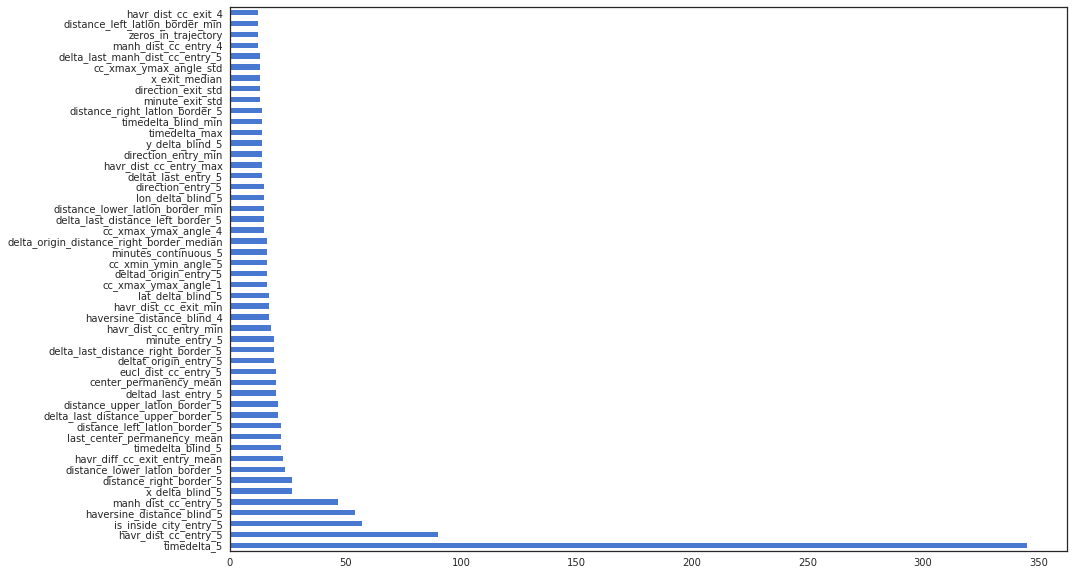

In [113]:
f, ax = plt.subplots(figsize=(15, 10))

feat_importances_gb = pd.Series(clf.feature_importances_, index=data_train[features].columns)
feat_importances_gb.nlargest(50).plot(kind='barh')

In [84]:
data_test = data_sequence[data_sequence.hash.isin(hashs_test)]
#data_test = test[test['x_exit_'+str(window_reference)].isnull()]

In [93]:
data_test[data_test.euclidean_distance_5.isnull()].shape

(33515, 1063)

In [182]:
ids = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)
ids = ids[ids.x_exit.isnull()]

In [183]:
data_test = data_test.merge(ids[['hash', 'trajectory_id']], on='hash')

In [184]:
clf.fit(data_train[features], data_train[target])
yhat = clf.predict(data_test[features])

In [185]:
pd.Series(yhat).value_counts()

0.0    25001
1.0     8514
dtype: int64

In [186]:
submission = pd.DataFrame(list(zip(data_test['trajectory_id'], yhat)), columns=['id', 'target'])

In [187]:
submission.to_csv('../data/submission3_victor_julio.csv', index=False)

# Preprocessed Data Saving

In [54]:
data_sequence.to_hdf('../data/preprocessed/data_sequence_alldata.hdf', key='final_alldata', mode='w')